In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: '../input'

In [ ]:
DATA_FOLDER = '../input'
transactions    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
test            = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))

this are the transactions we will groupby from, + category_id

In [3]:
transactions = pd.merge(transactions, items, on='item_id', how='left')
transactions = transactions.drop('item_name', axis=1)
transactions.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,37
1,03.01.2013,0,25,2552,899.00,1.0,58
2,05.01.2013,0,25,2552,899.00,-1.0,58
3,06.01.2013,0,25,2554,1709.05,1.0,58
4,15.01.2013,0,25,2555,1099.00,1.0,56


In [4]:
from itertools import product
index_cols = ['shop_id', 'item_id', 'date_block_num']

<h2>**1. Created a dataframe of all Date_block_num, Store and Item combinations:**</h2>
This is important because in the months we don't have a data for an item store combination, the machine learning algorithm needs to be specifically told that the sales is zero.

In [5]:
grid = []
for block_num in transactions['date_block_num'].unique():
    cur_shops = transactions.loc[transactions['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = transactions.loc[transactions['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])), dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype=np.int32)

Up to now we just crated a combinations of all possible triples (shop_id, item_id, date_block_num)

In [6]:
grid.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


<h2>3.Mean Encodings:</h2>

<h2>A)</h2>
So here we are grouping the transactions and applying the aggreated functions where ** sum of item_cnt_day will be our target variable** . in order to create the real target value 

In [7]:
mean_transactions = transactions.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day':'sum','item_price':np.mean}).reset_index()

After calculating target variable and price_mean we merge it back to our grid, and we add item_category_id

In [8]:
mean_transactions = pd.merge(grid,mean_transactions,on=['date_block_num', 'shop_id', 'item_id'],how='left').fillna(0)

In [9]:
mean_transactions = pd.merge(mean_transactions, items, on='item_id',how='left')

In [10]:
mean_transactions.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59


<h2>B)</h2>
Here we create **MEAN ENCODING**

Now we create additional encoding with aggregation functions on our data as follow: [('**item_price**',np.mean,'**avg**'),('**item_cnt_day**',np.sum,'**sum**'),('**item_cnt_day**',np.mean,'**avg**')]:


In [11]:
for type_id in ['item_id', 'shop_id', 'item_category_id']:
    for column_id, aggregator, aggtype in [('item_price',np.mean,'avg'),('item_cnt_day',np.sum,'sum'),('item_cnt_day',np.mean,'avg')]:
        
        mean_df = transactions.groupby([type_id,'date_block_num']).aggregate(aggregator).reset_index()[[column_id,type_id,'date_block_num']]
        mean_df.columns = [type_id+'_'+aggtype+'_'+column_id,type_id,'date_block_num']
        mean_transactions = pd.merge(mean_transactions, mean_df, on=['date_block_num',type_id], how='left')

In [12]:
mean_transactions.head(5)

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,999.00,18.0,1.0,820.174553,2017.0,1.092041,465.036007,6094.0,1.053414
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,899.00,0.0,0.0,820.174553,2017.0,1.092041,1401.858108,287.0,0.969595
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,1709.05,1.0,1.0,820.174553,2017.0,1.092041,1401.858108,287.0,0.969595
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,1098.85,2.0,1.0,820.174553,2017.0,1.092041,867.446992,268.0,1.007519
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,327.60,5.0,1.0,820.174553,2017.0,1.092041,443.330014,701.0,0.990113


These above lines add the following 9 features :

'item_id_avg_item_price'
'item_id_sum_item_cnt_day'
'item_id_avg_item_cnt_day'
'shop_id_avg_item_price',
'shop_id_sum_item_cnt_day'
'shop_id_avg_item_cnt_day'
'item_category_id_avg_item_price'
'item_category_id_sum_item_cnt_day'
'item_category_id_avg_item_cnt_day'

<h2>4.Lag Features:</h2>

What we do now? We created our mean encoding, but we can not using at prediction time (because we don't know the target variable so we can not encode it). What we do we create a lag for all this mean encoding features and we will use this lagged value (mean encoding at t-1, t-2 t-3) to predict our values

In [13]:
lag_variables  = list(mean_transactions.columns[7:])+['item_cnt_day']
lags = [1, 2, 3]
from tqdm import tqdm_notebook
for lag in tqdm_notebook(lags):

    sales_new_df = mean_transactions.copy()
    sales_new_df.date_block_num += lag
    sales_new_df = sales_new_df[['date_block_num','shop_id','item_id']+lag_variables]
    sales_new_df.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]
    mean_transactions = pd.merge(mean_transactions, sales_new_df,on=['date_block_num','shop_id','item_id'] ,how='left')

As you can see below, now we have the same mean_encoded features but also lagged, the number of columns now is around 50

In [14]:
mean_transactions.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day,item_id_avg_item_price_lag_1,item_id_sum_item_cnt_day_lag_1,item_id_avg_item_cnt_day_lag_1,shop_id_avg_item_price_lag_1,shop_id_sum_item_cnt_day_lag_1,shop_id_avg_item_cnt_day_lag_1,item_category_id_avg_item_price_lag_1,item_category_id_sum_item_cnt_day_lag_1,item_category_id_avg_item_cnt_day_lag_1,item_cnt_day_lag_1,item_id_avg_item_price_lag_2,item_id_sum_item_cnt_day_lag_2,item_id_avg_item_cnt_day_lag_2,shop_id_avg_item_price_lag_2,shop_id_sum_item_cnt_day_lag_2,shop_id_avg_item_cnt_day_lag_2,item_category_id_avg_item_price_lag_2,item_category_id_sum_item_cnt_day_lag_2,item_category_id_avg_item_cnt_day_lag_2,item_cnt_day_lag_2,item_id_avg_item_price_lag_3,item_id_sum_item_cnt_day_lag_3,item_id_avg_item_cnt_day_lag_3,shop_id_avg_item_price_lag_3,shop_id_sum_item_cnt_day_lag_3,shop_id_avg_item_cnt_day_lag_3,item_category_id_avg_item_price_lag_3,item_category_id_sum_item_cnt_day_lag_3,item_category_id_avg_item_cnt_day_lag_3,item_cnt_day_lag_3
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,999.00,18.0,1.0,820.174553,2017.0,1.092041,465.036007,6094.0,1.053414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,899.00,0.0,0.0,820.174553,2017.0,1.092041,1401.858108,287.0,0.969595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,1709.05,1.0,1.0,820.174553,2017.0,1.092041,1401.858108,287.0,0.969595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,1098.85,2.0,1.0,820.174553,2017.0,1.092041,867.446992,268.0,1.007519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,327.60,5.0,1.0,820.174553,2017.0,1.092041,443.330014,701.0,0.990113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h2>5. Fill NA with zeros:</h2>

In [15]:
mean_transactions = mean_transactions[mean_transactions['date_block_num']>12]

In [16]:
for feat in mean_transactions.columns:
    if 'item_cnt' in feat:
        mean_transactions[feat]=mean_transactions[feat].fillna(0)
    elif 'item_price' in feat:
        mean_transactions[feat]=mean_transactions[feat].fillna(mean_transactions[feat].median())


In the next line we choose to 'drop' some columns, what are these columns? are the one that we will not be able to have at prediction time.In other words these are the lagged columns for the target variable


In [17]:
cols_to_drop = lag_variables[:-1] + ['item_price', 'item_name'] # dropping all target variables but not "item_cnt_day" cause is target

In [18]:
training = mean_transactions.drop(cols_to_drop,axis=1)

<h2>6. Now we can finally train the XGB model</h2>
I wrote a really simple xgb process to train a model with the given data model, training the xgb will takes more or less 10 mins

In [19]:
import xgboost as xgb

In [20]:
xgbtrain = xgb.DMatrix(training.iloc[:, training.columns != 'item_cnt_day'].values, training.iloc[:, training.columns == 'item_cnt_day'].values)

In [21]:
param = {'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':1000, 
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'} # random parameters
bst = xgb.train(param, xgbtrain)

[13:07:17] WARNING: /workspace/src/learner.cc:685: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


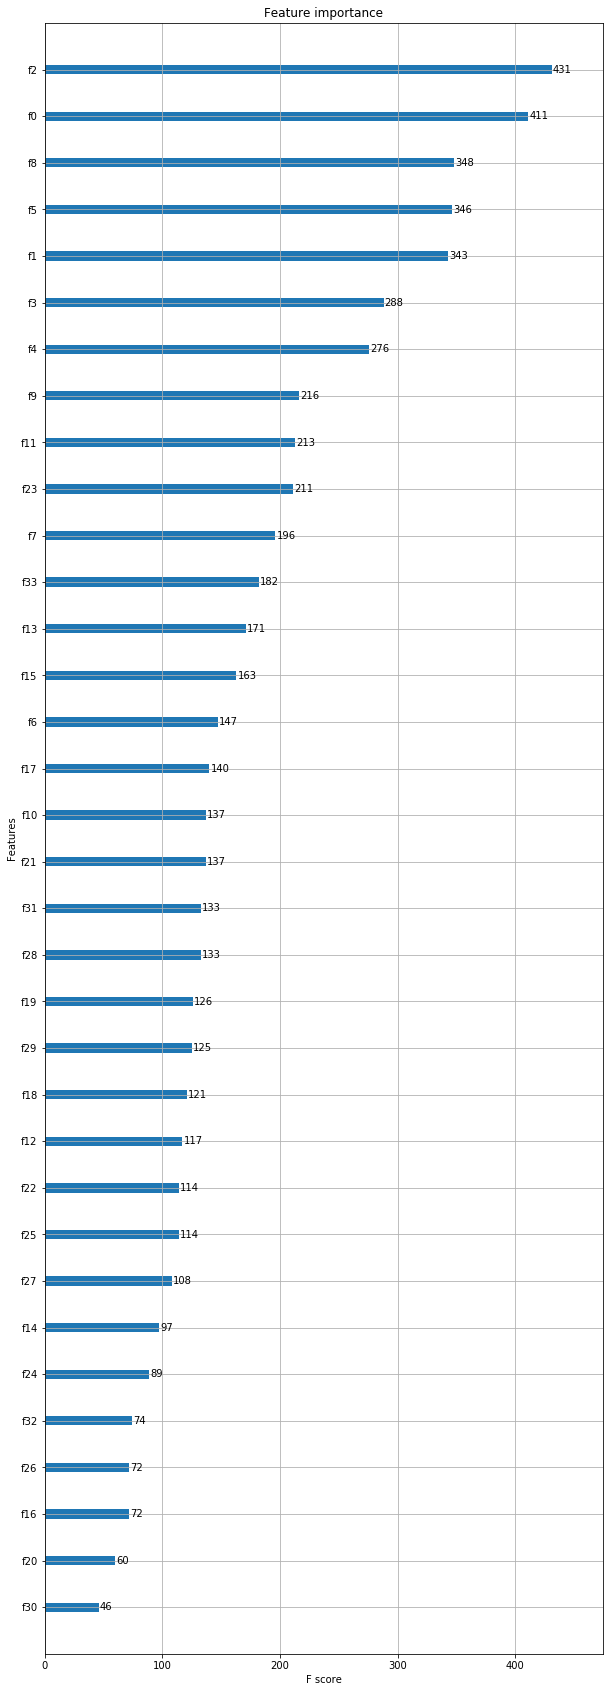

In [22]:
x=xgb.plot_importance(bst)
x.figure.set_size_inches(10, 30) 

the most important features (2 0 5 8 4 1 3 9 11) are:

In [23]:
cols = list(training.columns)
del cols[cols.index('item_cnt_day')] # eliminate target feature col name

In [24]:
[cols[x] for x in [2, 0, 5, 8, 4, 1, 3, 9, 11]]

['date_block_num',
 'shop_id',
 'item_id_sum_item_cnt_day_lag_1',
 'shop_id_sum_item_cnt_day_lag_1',
 'item_id_avg_item_price_lag_1',
 'item_id',
 'item_category_id',
 'shop_id_avg_item_cnt_day_lag_1',
 'item_cnt_day_lag_3']

<h2>7. Preparing predictions</h2>
now we need to embrace the hard task of preparing prediction data without bugs

In [25]:
training.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_day',
       'item_category_id', 'item_id_avg_item_price_lag_1',
       'item_id_sum_item_cnt_day_lag_1', 'item_id_avg_item_cnt_day_lag_1',
       'shop_id_avg_item_price_lag_1', 'shop_id_sum_item_cnt_day_lag_1',
       'shop_id_avg_item_cnt_day_lag_1',
       'item_category_id_avg_item_price_lag_1',
       'item_category_id_sum_item_cnt_day_lag_1',
       'item_category_id_avg_item_cnt_day_lag_1', 'item_cnt_day_lag_1',
       'item_id_avg_item_price_lag_2', 'item_id_sum_item_cnt_day_lag_2',
       'item_id_avg_item_cnt_day_lag_2', 'shop_id_avg_item_price_lag_2',
       'shop_id_sum_item_cnt_day_lag_2', 'shop_id_avg_item_cnt_day_lag_2',
       'item_category_id_avg_item_price_lag_2',
       'item_category_id_sum_item_cnt_day_lag_2',
       'item_category_id_avg_item_cnt_day_lag_2', 'item_cnt_day_lag_2',
       'item_id_avg_item_price_lag_3', 'item_id_sum_item_cnt_day_lag_3',
       'item_id_avg_item_cnt_day_lag_3', 'shop_id_avg_i

so we need these columns above without 'item_cnt_day', and we have only the column below

In [26]:
test            = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


So we need to manipulate the training set similarly to how we did in the first part of the notebook.
- add date_block_num = 34
- add category_id
- add lagging

In [27]:
test['date_block_num'] = 34

In [28]:
test = pd.merge(test, items, on='item_id', how='left')

In [29]:
from tqdm import tqdm_notebook
for lag in tqdm_notebook(lags):

    sales_new_df = mean_transactions.copy()
    sales_new_df.date_block_num += lag
    sales_new_df = sales_new_df[['date_block_num','shop_id','item_id']+lag_variables]
    sales_new_df.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]
    test = pd.merge(test, sales_new_df,on=['date_block_num','shop_id','item_id'] ,how='left')

**They look the same!**

In [30]:
_test = set(test.drop(['ID', 'item_name'], axis=1).columns)
_training = set(training.drop('item_cnt_day',axis=1).columns)
for i in _test:
    assert i in _training
for i in _training:
    assert i in _test

In [31]:
assert _training == _test

In [32]:
test = test.drop(['ID', 'item_name'], axis=1)

In [33]:
for feat in test.columns:
    if 'item_cnt' in feat:
        test[feat]=test[feat].fillna(0)
    elif 'item_price' in feat:
        test[feat]=test[feat].fillna(test[feat].median())

lets check that our lag is actually correct

In [34]:
test[['shop_id','item_id']+['item_cnt_day_lag_'+str(x) for x in [1,2,3]]].head()

,shop_id,item_id,item_cnt_day_lag_1,item_cnt_day_lag_2,item_cnt_day_lag_3
0,5,5037,0.0,1.0,3.0
1,5,5320,0.0,0.0,0.0
2,5,5233,1.0,3.0,1.0
3,5,5232,0.0,0.0,1.0
4,5,5268,0.0,0.0,0.0


In [35]:
print(training[training['shop_id'] == 5][training['item_id'] == 5037][training['date_block_num'] == 33]['item_cnt_day'])
print(training[training['shop_id'] == 5][training['item_id'] == 5037][training['date_block_num'] == 32]['item_cnt_day'])
print(training[training['shop_id'] == 5][training['item_id'] == 5037][training['date_block_num'] == 31]['item_cnt_day'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


10849431    0.0
Name: item_cnt_day, dtype: float64
10605772    1.0
Name: item_cnt_day, dtype: float64
10396094    3.0
Name: item_cnt_day, dtype: float64


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


the lagged value for (5	5037) actually correspond, looks like we dont have bugs!

<h2>**8. Predict**

In [36]:
xgbpredict = xgb.DMatrix(test.values)

In [37]:
pred = bst.predict(xgbpredict)

In [38]:
pd.Series(pred).describe()

count    214200.000000
mean          0.309462
std           2.153762
min          -0.898389
25%           0.065981
50%           0.132045
75%           0.257985
max         404.595276
dtype: float64

In [39]:
pred = pred.clip(0, 20)

In [40]:
pred.sum()

62546.246

In [41]:
pd.Series(pred).describe()

count    214200.000000
mean          0.292062
std           0.744270
min           0.000000
25%           0.065981
50%           0.132045
75%           0.257985
max          20.000000
dtype: float64

In [42]:
sub_df = pd.DataFrame({'ID':test.index,'item_cnt_month': pred })

In [ ]:
sub_df.head()

In [ ]:
sub_df.to_csv('submission.csv',index=False)